In [55]:
import subprocess

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt 

from od_perturber import od_perturber
from output_reader import output_reader

# Automated OD trials

This is written to be run on a **Linux** machine.

### Automate TSTT calculation for an individual OD matrix perturbation

In [3]:
def tap_trial(
            netFileName,
            demandFileName, 
            perturbType="normal", 
            norm_mean=1, 
            norm_sd=.1, 
            uniform_low=.9, 
            uniform_high=1.1,
            nodesPerturbedAlways=[],
            nodesPerturbedIfOrig=[],
            nodesPerturbedIfDest=[],
            returnDataFrame=False
):
    '''
    Generate a new TSTT calculation for a specific network, trip demands, and perturbation combination.
    '''
    od_perturber(
        demandFileName, 
        perturbType, 
        norm_mean, 
        norm_sd, 
        uniform_low, 
        uniform_high,
        nodesPerturbedAlways,
        nodesPerturbedIfOrig,
        nodesPerturbedIfDest
    )
    subprocess.Popen("tap-b/bin/tap " + netFileName + " trips_perturbed.tntp", shell=True).wait()
    if returnDataFrame:
        return output_reader("full_log.txt")
    else:
        _,tstt = output_reader("full_log.txt")
        return tstt

df, tstt = tap_trial("SiouxFalls_net.tntp", "SiouxFalls_trips.tntp", returnDataFrame=True)
tstt

7545042.096875504

In [4]:
df.head()

,OD,flow,cost,der
ID,,,,
0,"(1,2)",4426.697929,6.000768,0.000001
1,"(1,3)",8023.515936,4.008289,0.000004
2,"(2,1)",4703.696103,6.000979,0.000001
3,"(2,6)",5901.953126,6.505757,0.001021
4,"(3,1)",8037.612046,4.008347,0.000004


### Generate basic trials on Sioux Falls

In [7]:
sds = [0.5, 0.1, 0.01, 0.001, 0]
means = [0.5, 0.9, 0.95, 1.0, 1.05, 1.1, 1.5, 2]
dfres = pd.DataFrame(columns=['mean', 'sd', 'tstt'])
i=0
for mean in means:
    for sd in sds:
        tstt = tap_trial("SiouxFalls_net.tntp", "SiouxFalls_trips.tntp", norm_mean=mean, norm_sd=sd, returnDataFrame=False)
        dfres.loc[i] = [mean, sd, tstt]
        i += 1
dfres.to_csv("res.csv")

### Get TSTTs for many trials (with fixed perturbation criteria) at once

In [17]:
def tap_multi_trial(
            netFileName,
            demandFileName, 
            n, 
            perturbType="normal", 
            norm_mean=1, 
            norm_sd=.1, 
            uniform_low=.9, 
            uniform_high=1.1,
            nodesPerturbedAlways=[],
            nodesPerturbedIfOrig=[],
            nodesPerturbedIfDest=[]
):
    return [tap_trial(
        netFileName,
        demandFileName, 
        perturbType, 
        norm_mean, 
        norm_sd, 
        uniform_low, 
        uniform_high,
        nodesPerturbedAlways,
        nodesPerturbedIfOrig,
        nodesPerturbedIfDest,
        returnDataFrame=False
    ) for i in range(n)]

tstts = tap_multi_trial("SiouxFalls_net.tntp", "SiouxFalls_trips.tntp", 10)
print(tstts)

### Visualize TSTT from many trials

In [24]:
df = pd.read_csv('Sioux Falls TSTT mean 1 sd 0.3 Kolmogrov-Smirnov Test.csv', usecols=['TSTT'])
df.head()

,TSTT
0,6123595
1,6124233
2,6212161
3,6221346
4,6222313


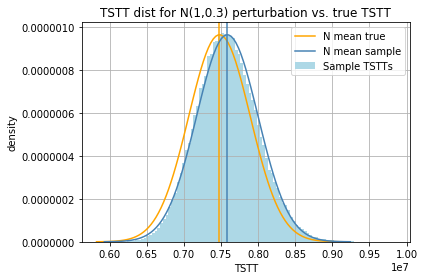

  true mean: 7480155.253
sample mean: 7585696.041981611
sample stdv: 414019.68137887685


In [109]:
def visualize(tstts, mean_true, plot_true_mean=True, img_title=None, img_filename=None, verbose_output=False):
    mean_sample = tstts.mean()
    sd = tstts.std()
    xsnorm = np.linspace(mean_sample - 4*sd, mean_sample + 4*sd, 100)
    xtnorm = np.linspace(mean_true - 4*sd, mean_true + 4*sd, 100)

    tstts.hist(bins=100, label='Sample TSTTs', color='lightblue', density=True)
    if plot_true_mean:
        plt.axvline(x=mean_true, color='orange')
        plt.plot(xtnorm, stats.norm.pdf(xtnorm, mean_true, sd), color='orange', label='N mean true')
    plt.axvline(x=mean_sample, color='steelblue')
    plt.plot(xsnorm, stats.norm.pdf(xsnorm, mean_sample, sd), color='steelblue', label='N mean sample')
    
    if img_title:
        plt.title(img_title)
    plt.ylabel('density')
    plt.xlabel('TSTT')
    plt.legend()
    plt.tight_layout()
    if img_filename:
        plt.savefig(img_filename, dpi='figure')
    plt.show()
    
    if verbose_output:
        print('  true mean:', mean_true)
        print('sample mean:', mean_sample)
        print('sample stdv:', sd)
    
    return mean_sample, sd

mean_true = 7480155.253
n1sdp3_mean, n1sdp3_sd = visualize(df['TSTT'], mean_true, img_title='TSTT dist for N(1,0.3) perturbation vs. true TSTT', img_filename='normcompare.png', verbose_output=True)

## Monte Carlo simulations

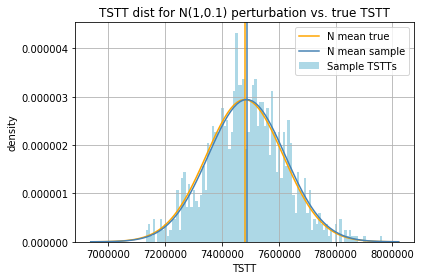

  true mean: 7480155.253
sample mean: 7487364.638321927
sample stdv: 135556.9634314383


In [87]:
def monte_carlo(
    mean_true,    
    
    netFileName,
    demandFileName, 
    n, 
    perturbType="normal", 
    norm_mean=1, 
    norm_sd=.1, 
    uniform_low=.9, 
    uniform_high=1.1,
    nodesPerturbedAlways=[],
    nodesPerturbedIfOrig=[],
    nodesPerturbedIfDest=[],
    
    trials_csv=None,
    
    plot_true_mean=True,
    img_title=None, 
    img_filename=None, 
    verbose_output=False
):
    tstts = pd.Series(tap_multi_trial(
        netFileName,
        demandFileName, 
        n,
        perturbType, 
        norm_mean, 
        norm_sd, 
        uniform_low, 
        uniform_high,
        nodesPerturbedAlways,
        nodesPerturbedIfOrig,
        nodesPerturbedIfDest
    ))
    if trials_csv:
        pd.DataFrame({
            'mean': np.ones(n)*norm_mean,
            'sd': np.ones(n)*norm_sd,
            'TSTT': tstts
        } if perturbType is 'normal' else {
            'low': np.ones(n)*uniform_low,
            'high': np.ones(n)*uniform_high,
            'TSTT': tstts
        }).to_csv(trials_csv)
    return visualize(tstts, mean_true, plot_true_mean, img_title=img_title, img_filename=img_filename, verbose_output=verbose_output)

n1sdp1_mean, n1sdp1_sd = monte_carlo(mean_true, 
                                     "SiouxFalls_net.tntp", 
                                     "SiouxFalls_trips.tntp", 
                                     1000, 
                                     trials_csv='n(1,p1).csv', 
                                     img_title='TSTT dist for N(1,0.1) perturbation vs. true TSTT', 
                                     img_filename='n(1,p1).png', 
                                     verbose_output=True)

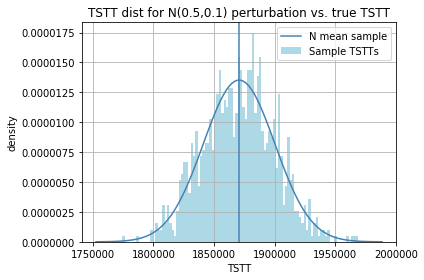

  true mean: 7480155.253
sample mean: 1870777.075757287
sample stdv: 29495.780865486373


In [112]:
np5sdp1_mean, np5sdp1_sd = monte_carlo(mean_true, 
                                       "SiouxFalls_net.tntp", 
                                       "SiouxFalls_trips.tntp", 
                                       1000, 
                                       norm_mean=.5,
                                       trials_csv='n(p5,p1).csv', 
                                       plot_true_mean=False,
                                       img_title='TSTT dist for N(0.5,0.1) perturbation vs. true TSTT', 
                                       img_filename='n(p5,p1).png', 
                                       verbose_output=True)

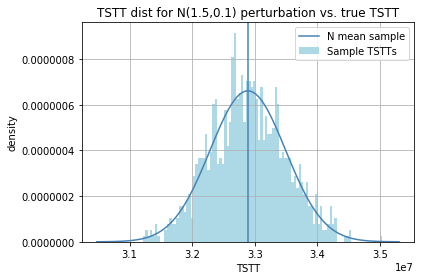

  true mean: 7480155.253
sample mean: 32888137.60132828
sample stdv: 603552.8894860788


In [111]:
n1p5sdp1_mean, n1p5sdp1_sd = monte_carlo(mean_true,
                                         "SiouxFalls_net.tntp", 
                                         "SiouxFalls_trips.tntp", 
                                         1000, 
                                         norm_mean=1.5,
                                         trials_csv='n(1p5,p1).csv',
                                         plot_true_mean=False,
                                         img_title='TSTT dist for N(1.5,0.1) perturbation vs. true TSTT', 
                                         img_filename='n(1p5,p1).png', 
                                         verbose_output=True)